In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import seaborn as sns
import pickle
import os
import pandas as pd
import torch
import io

In [38]:
data_dir = '/Volumes/green_groups_sms_public/Projects_Current/Ambizione/10_Studies/2_SMART/valence_arousal_kss_paper/runs_results'
file = 'outputs_kss_12h_hr+act+rr.pkl'
folder = '/Volumes/green_groups_sms_public/Projects_Current/Ambizione/10_Studies/2_SMART/valence_arousal_kss_paper/results_kss_12h'

In [39]:
df_results = pd.DataFrame()
#for f in os.listdir(folder):
accuracy_all = []
f1_all = []
precision_all = []
recall_all = []
auroc_all = []
auprc_all = []
auroc_scores_list = []
auprc_scores_list = []

#mods = f.split('_')[-1].split('.')[0]
results = pd.read_pickle(os.path.join(folder,file))

for f in results:
    fold = results[f]
    outputs = fold['outputs']
    targets = fold['targets']
    y_true = fold['y_true']
    y_scores = fold['y_scores']

    metrics = skm.classification_report(targets.cpu(), outputs,output_dict=True)
    auroc_all.append(skm.roc_auc_score(y_true, y_scores, multi_class='ovr', average='macro'))
    auprc_all.append(skm.average_precision_score(y_true,y_scores,average='macro'))
    accuracy_all.append(metrics['accuracy'])
    metrics_macro = metrics['macro avg']
    f1_all.append(metrics_macro['f1-score'])
    precision_all.append(metrics_macro['precision'])
    recall_all.append(metrics_macro['recall'])

    #y_true = y_true.cpu()
    #y_scores = y_scores.cpu()

    # Calculate AUROC for each class
    auroc_scores = []
    for i in range(y_true.shape[1]):
        try:
            auroc = skm.roc_auc_score(y_true[:, i], y_scores[:, i])
            auroc_scores.append(auroc)
        except:
            auroc_scores.append(np.nan)

    # Calculate AUPRC for each class
    auprc_scores = []
    for i in range(y_true.shape[1]):
        try:
            auprc = skm.average_precision_score(y_true[:, i], y_scores[:, i])
            auprc_scores.append(auprc)
        except:
            auprc_scores.append(np.nan)

    # Append scores to the lists
    auroc_scores_list.append(auroc_scores)
    auprc_scores_list.append(auprc_scores)
'''
row = {'mod':mods,
'accuracy':str(np.mean(accuracy_all).round(2))+ ' (' + str(np.std(accuracy_all).round(2))+')',
'f1':str(np.mean(f1_all).round(2)) + ' (' + str(np.std(f1_all).round(2))+')',
'precision': str(np.mean(precision_all).round(2)) + ' (' + str(np.std(precision_all).round(2))+')',
'recall': str(np.mean(precision_all).round(2)) + ' (' + str(np.std(precision_all).round(2))+')',
'auroc': str(np.mean(auroc_all).round(2)) + ' (' + str(np.std(auroc_all).round(2))+')',
'auprc': str(np.mean(auprc_all).round(2)) + ' (' + str(np.std(auprc_all).round(2))+')'}

    #df_results=pd.concat((df_results,pd.DataFrame(row,index=[0])),ignore_index=True)

'''




"\nrow = {'mod':mods,\n'accuracy':str(np.mean(accuracy_all).round(2))+ ' (' + str(np.std(accuracy_all).round(2))+')',\n'f1':str(np.mean(f1_all).round(2)) + ' (' + str(np.std(f1_all).round(2))+')',\n'precision': str(np.mean(precision_all).round(2)) + ' (' + str(np.std(precision_all).round(2))+')',\n'recall': str(np.mean(precision_all).round(2)) + ' (' + str(np.std(precision_all).round(2))+')',\n'auroc': str(np.mean(auroc_all).round(2)) + ' (' + str(np.std(auroc_all).round(2))+')',\n'auprc': str(np.mean(auprc_all).round(2)) + ' (' + str(np.std(auprc_all).round(2))+')'}\n\n    #df_results=pd.concat((df_results,pd.DataFrame(row,index=[0])),ignore_index=True)\n\n"

In [17]:
print('accuracy: ' + str(np.mean(accuracy_all)) + '(' + str(np.std(accuracy_all))+')')
print('f1: ' + str(np.mean(f1_all)) + '(' + str(np.std(f1_all))+')')
print('precision: ' + str(np.mean(precision_all)) + '(' + str(np.std(precision_all))+')')
print('recall: ' + str(np.mean(recall_all)) + '(' + str(np.std(recall_all))+')')
print('auroc: ' + str(np.mean(auroc_all)) + '(' + str(np.std(auroc_all))+')')
print('auprc: ' + str(np.mean(auprc_all)) + '(' + str(np.std(auprc_all))+')')

accuracy: 0.5304271708683473(0.0508609665799136)
f1: 0.49922835340658134(0.0551611799024025)
precision: 0.5111919202971207(0.06213022135946858)
recall: 0.49751048044873203(0.05252608809636689)
auroc: 0.6984343054999538(0.03275475284405748)
auprc: 0.5427819547206001(0.046437776356574825)


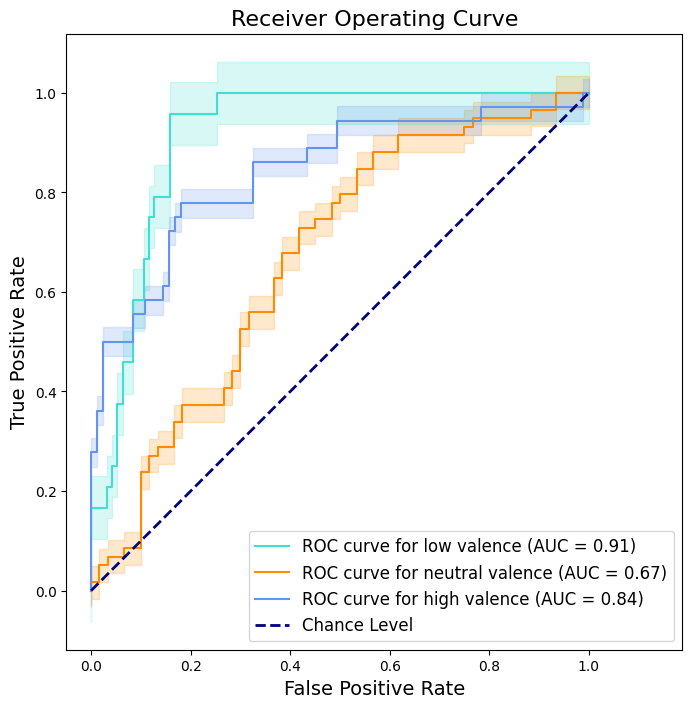

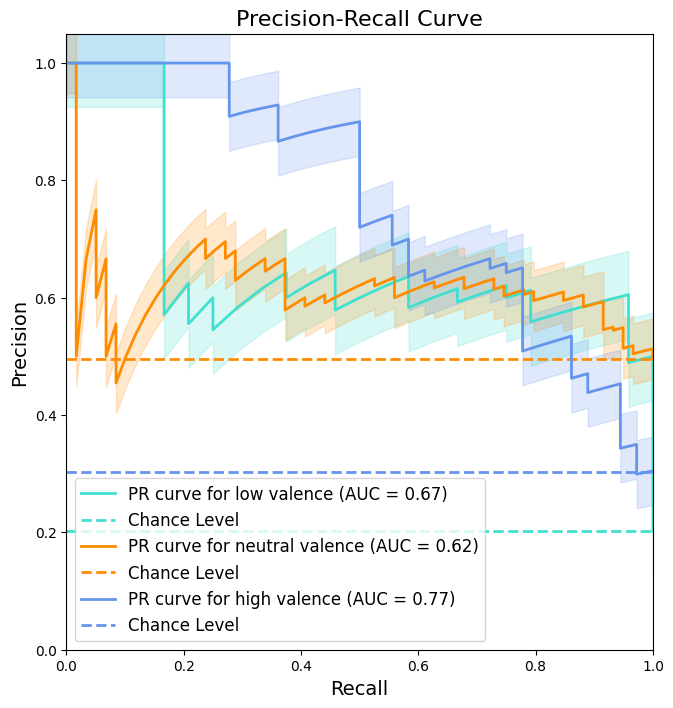

In [29]:
# Convert the lists to NumPy arrays for easier handling
auroc_scores_array = np.array(auroc_scores_list)
auprc_scores_array = np.array(auprc_scores_list)

# Calculate standard deviation across folds
std_auroc = np.nanstd(auroc_scores_array, axis=0)
std_auprc = np.nanstd(auprc_scores_array, axis=0)

# Plotting ROC curves with shaded area for standard deviation
fig, ax = plt.subplots(figsize=(8, 8))
colors = ["turquoise", "darkorange", "cornflowerblue"]
target_names = ["low valence", "neutral valence", "high valence"]

for class_id, color in zip(range(3), colors):
    display = skm.RocCurveDisplay.from_predictions(
        y_true[:, class_id],
        y_scores[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )
    if class_id == 2:
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance Level')

    # Plot shaded area for standard deviation
    ax.fill_between(display.fpr, display.tpr - std_auroc[class_id], display.tpr + std_auroc[class_id],
                    color=color, alpha=0.2)

plt.axis("square")
plt.xlabel("False Positive Rate",fontsize= 14)
plt.ylabel("True Positive Rate",fontsize= 14)
plt.title("Receiver Operating Curve",fontsize= 16)
plt.legend(fontsize=12)
plt.savefig(folder+'auroc_valence.svg',format='svg',dpi=300)
plt.show()

# Plotting PR curves with shaded area for standard deviation
fig2, ax2 = plt.subplots(figsize=(8, 8))

for class_id, color in zip(range(3), colors):
    precision, recall, _ = skm.precision_recall_curve(y_true[:, class_id], y_scores[:, class_id])
    average_precision = skm.average_precision_score(y_true[:, class_id], y_scores[:, class_id])

    ax2.plot(recall, precision, color=color, lw=2,
             label=f"PR curve for {target_names[class_id]} (AUC = {average_precision:.2f})")
    chance_precision = sum(y_true[:, class_id]) / len(y_true[:, class_id])
    ax2.plot([0, 1], [chance_precision, chance_precision], color=color, lw=2, linestyle='--', label='Chance Level')

    # Plot shaded area for standard deviation
    ax2.fill_between(recall, precision - std_auprc[class_id], precision + std_auprc[class_id],
                     color=color, alpha=0.2)

plt.axis("square")
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall',fontsize= 14)
ax2.set_ylabel('Precision',fontsize = 14)
ax2.set_title('Precision-Recall Curve',fontsize=16)
ax2.legend(loc="lower left",fontsize=12)
plt.savefig(folder+'auprc_valence.svg',format='svg',dpi=300)
plt.show()

In [6]:
print('precision: ' + str(np.mean(precision_all)) + '(' + str(np.std(precision_all))+')')
print('recall: ' + str(np.mean(recall_all)) + '(' + str(np.std(recall_all))+')')

precision: 0.6150762950992669(0.045519501271604514)
recall: 0.5859048964218455(0.05229253621693474)


In [40]:
from sklearn.metrics import confusion_matrix
import numpy as np
import torch

average_cm = np.zeros((3,3))

# Perform 10-fold cross-validation

for f in results:
    class_counts = []
    fold = results[f]
    outputs = fold['outputs']
    targets = fold['targets']

    # Compute the confusion matrix for this fold
    cm_fold = confusion_matrix(targets, outputs)

    for i in np.unique(targets):
    
        class_counts.append(torch.sum(targets == i).numpy().item())
    
    cm_fold = (cm_fold.T / class_counts).T
       
    # Accumulate the confusion matrix values
    average_cm += cm_fold

# Calculate the average confusion matrix
average_cm /= 10

print("Average Confusion Matrix:")
print(average_cm)

Average Confusion Matrix:
[[0.60873227 0.32007979 0.07118794]
 [0.28056973 0.55119048 0.1682398 ]
 [0.14692029 0.52047101 0.3326087 ]]


In [41]:
(average_cm *100)

array([[60.87322695, 32.00797872,  7.11879433],
       [28.05697279, 55.11904762, 16.82397959],
       [14.69202899, 52.04710145, 33.26086957]])

<AxesSubplot: >

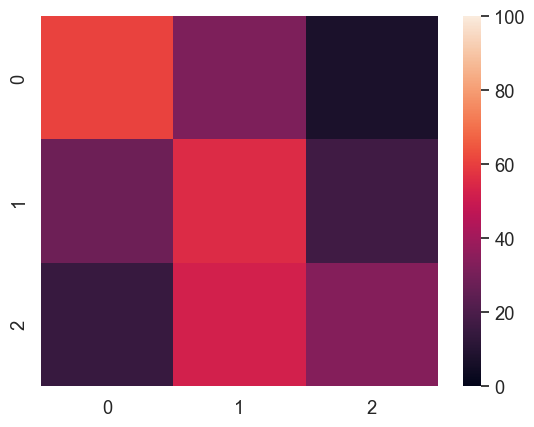

In [42]:
sns.heatmap(average_cm *100,vmin=0,vmax=100,)

class_counts[int(0)]

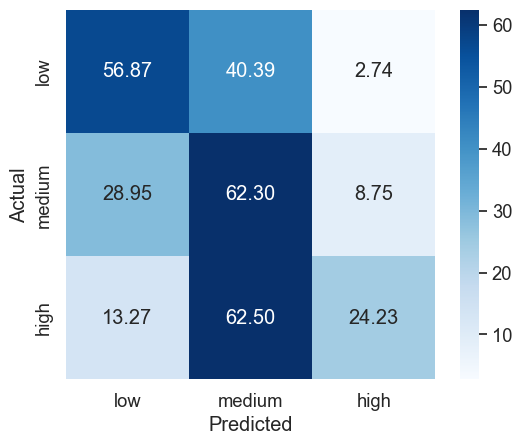

In [45]:
# Replace the values below with your actual confusion matrix
confusion_matrix = np.array([[56.86613475, 40.39007092,  2.74379433],
       [28.95480226, 62.29661017,  8.74858757],
       [13.26923077, 62.5       , 24.23076923]])

# Define class labels (replace with your actual class labels)
class_labels = ['low', 'medium', 'high']

# Create a Seaborn heatmap
#plt.figure(figsize=(8, 8))  # Make the figure square
sns.set(font_scale=1.2)  # Increase font size
sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, cbar=True, square=True)

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Display the plot
plt.show()

In [44]:
plt.savefig('/users/crisgallego/Documents/phd/03_Projects/03_SMART_study/valence_arousal_kss_paper/figures/cm_all_kss.png')

<Figure size 640x480 with 0 Axes>

In [6]:
## Ablation study with different hours before the questionnaire
import re
# Custom sorting function using regular expressions
def custom_sort(item):
    match = re.search(r'(\D*)(\d*)', item)
    if match:
        return (match.group(1), int(match.group(2)))
    else:
        return (item, 0)

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


folder = '/Volumes/green_groups_sms_public/Projects_Current/Ambizione/51_Datasets/outputs_valence_all_hours'
files = os.listdir(folder)
sorted_files = sorted(files, key=custom_sort)

In [7]:
for f in sorted_files:
    df = CPU_Unpickler(os.path.join(folder,f)).load()

TypeError: file must have 'read' and 'readline' attributes

In [28]:
os.path.join(folder,f)

'/Volumes/green_groups_sms_public/Projects_Current/Ambizione/51_Datasets/outputs_valence_all_hours/outputs_valence_all_1.pkl'